# Analysis of NYPD Hate Crimes Dataset — 2019-01-01 to 2024-06-25 

This notebook analyzes NYPD hate crime data [available online at NYC OpenData](https://data.cityofnewyork.us/Public-Safety/NYPD-Hate-Crimes/bqiq-cu78/about_data) and updated quarterly by law.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

This cell imports the NYPD csv and sets the datatypes for codes/incident-level ID numbers to strings and parses the date columns so they're mutually intelligible. It also quickly identifies the number of rows, the earliest incident report date and the most recent report date in the imported dataset. 

In [2]:
%%time

dtypes = {
    "Full Complaint ID":"str",
    "Complaint Precinct Code":"str",
    "Arrest ID":"str"
}

date_cols = ['Record Create Date', 'Arrest Date'] 

hate_crimes = pd.read_csv('../data/NYPD_Hate_Crimes_20240929.csv', dtype=dtypes, parse_dates=date_cols)

print(f"{len(hate_crimes)} rows in imported dataframe") 
print(f"Earliest record date: {hate_crimes['Record Create Date'].min()}, Latest date: {hate_crimes['Record Create Date'].max()}")

3078 rows in imported dataframe
Earliest record date: 2019-01-01 00:00:00, Latest date: 2024-06-25 00:00:00
CPU times: user 20.3 ms, sys: 3.67 ms, total: 24 ms
Wall time: 30.7 ms


This cell simplifies the mass number of `PD Code Descriptions` used in the dataset by collecting them in a dictionary with key descriptive categories, and applies those categories in a new column: `Code Category`, using a for loop that checks the `PD Code Descriptions` value for a row against the `codes_categorized` dictionary. 

These categories are manual and associative; they could be tweaked for different analyses focused on different subsets of PD Code incidents. 

In [3]:
codes_categorized = {
    'Harassment': [
        'AGGRAVATED HARASSMENT 1',
        'AGGRAVATED HARASSMENT 2', 
        'HARASSMENT,SUBD 3,4,5',
        'HARASSMENT,SUBD 1,CIVILIAN',
        'MENACING,UNCLASSIFIED'
    ],
    'Burglary/Robbery': [
        'ROBBERY,PERSONAL ELECTRONIC DEVICE',
        'LARCENY,GRAND FROM PERSON,UNCL',
        'LARCENY,GRAND FROM PERSON,PERSONAL ELECTRONIC DEVICE(SNATCH)',
        'LARCENY,GRAND FROM OPEN AREAS, UNATTENDED',
        'LARCENY,GRAND FROM RESIDENCE, UNATTENDED',
        'ROBBERY,CLOTHING',
        'LARCENY,PETIT FROM BUILDING,UN',
        'ROBBERY,NECKCHAIN/JEWELRY',
        'BURGLARY,TRUCK NIGHT',
        'ROBBERY,OPEN AREA UNCLASSIFIED',
        'LARCENY,PETIT FROM BUILDING,UNATTENDED, PACKAGE THEFT INSIDE',
        'ROBBERY,POCKETBOOK/CARRIED BAG',
        'ROBBERY,PUBLIC PLACE INSIDE',
        'ROBBERY,COMMERCIAL UNCLASSIFIED',
        'ROBBERY,CAR JACKING',
        'ROBBERY,RESIDENTIAL COMMON AREA',
        'BURGLARY,RESIDENCE,UNKNOWN TIM',
        'BURGLARY,UNCLASSIFIED,NIGHT',
        'LARCENY,PETIT BY ACQUIRING LOS',
        'LARCENY,PETIT FROM OPEN AREAS,',
        'LARCENY,PETIT FROM AUTO',
        'LARCENY,GRAND FROM BUILDING (NON-RESIDENCE) UNATTENDED',
        'LARCENY,GRAND BY FALSE PROMISE-IN PERSON CONTACT',
        'ROBBERY,BEGIN AS SHOPLIFTING',
        'LARCENY,GRAND BY THEFT OF CREDIT CARD',
        'LARCENY,PETIT FROM STORE-SHOPL',
        'LARCENY,GRAND FROM PERSON, BAG OPEN/DIP',
        'BURGLARY,COMMERCIAL,NIGHT',
        'ROBBERY,ON BUS/ OR BUS DRIVER',
        'ROBBERY,DWELLING',
        'BURGLARY,COMMERCIAL,DAY',
        'LARCENY,GRAND BY EXTORTION'
    ],
    'Violent': [
        'ASSAULT 3',
        'ASSAULT 2,1,UNCLASSIFIED',
        'SEXUAL ABUSE 3,2',
        'MANSLAUGHTER,UNCLASSIFIED - NO',
        'STRANGULATION 1ST',
        'ASSAULT POLICE/PEACE OFFICER',
        'HOMICIDE,NEGLIGENT,UNCLASSIFIE',
        'SEXUAL ABUSE',
        'IMPRISONMENT 1,UNLAWFUL',
        'RAPE 1',
        'MURDER,UNCLASSIFIED',
        'OBSTR BREATH/CIRCUL',
        'ASSAULT OTHER PUBLIC SERVICE EMPLOYEE'
    ],
    'Miscellaneous': [
        'INVESTIGATE CHILD ABUSE',
        'CHILD, ENDANGERING WELFARE',
        'FRAUD,UNCLASSIFIED-MISDEMEANOR',
        'MAKING TERRORISTIC THREAT',
        'UNCLASSIFIED COMPLAINT',
        'FALSE REPORT 1,FIRE',
        'RECKLESS ENDANGERMENT 1',
        'RECKLESS ENDANGERMENT 2',
        'TERRORISM PROVIDE SUPPORT',
        'SUPP. ACT TERR 2ND',
        'MENACING 1ST DEGREE (VICT PEAC',
        'MENACING 1ST DEGREE (VICT NOT',
        'TRESPASS 3, CRIMINAL',
        'CRIMINAL CONTEMPT 1',
        'RESISTING ARREST',
        'WEAPONS POSSESSION 3',
        'CONTROLLED SUBSTANCE,POSSESS.',
        'CRIMINAL POSSESSION WEAPON'
    ],
    'Criminal Mischief': [
        'CRIMINAL MIS 2 & 3',
        'MISCHIEF, CRIMINAL 3 & 2, OF M',
        'CRIMINAL MISCHIEF,UNCLASSIFIED 4',
        'MISCHIEF,CRIMINAL,    UNCL 2ND',
        'MISCHIEF, CRIMINAL 4, OF MOTOR',
        'MISCHIEF, CRIMINAL 4, BY FIRE',
        'CRIMINAL MISCHIEF 4TH, GRAFFIT',
        'MISCHIEF, CRIMINAL 3&2, BY FIR',
        'TAMPERING 3,2, CRIMINAL'
    ],
    'Arson': [
        'ARSON 1',
        'ARSON 2,3,4'
    ]
}

def get_code_category(pd_code):
    for category, codes in codes_categorized.items():
        if pd_code in codes:
            return category
    return 'Uncategorized'

hate_crimes['Code Category'] = hate_crimes['PD Code Description'].apply(get_code_category)

This cell sets the index of the dataframe to the date the report was made and saves a copy of the modified dataset (with the new code category column) to the output folder.

In [4]:
hate_crimes_over_time = hate_crimes.set_index('Record Create Date')
hate_crimes_over_time.head()
hate_crimes_over_time.to_csv("../output/hate_crimes_w_codecats.csv")

This section examines the count of incidents per code category, borough, and specific and grouped bias motive. 

In [5]:
hate_crimes_over_time['Code Category'].value_counts()

Code Category
Harassment           1265
Violent               906
Criminal Mischief     636
Burglary/Robbery      174
Miscellaneous          94
Arson                   3
Name: count, dtype: int64

In [6]:
hate_crimes_over_time["Patrol Borough Name"].value_counts()

Patrol Borough Name
PATROL BORO MAN SOUTH        705
PATROL BORO BKLYN SOUTH      597
PATROL BORO BKLYN NORTH      462
PATROL BORO MAN NORTH        448
PATROL BORO QUEENS NORTH     355
PATROL BORO QUEENS SOUTH     199
PATROL BORO BRONX            195
PATROL BORO STATEN ISLAND    117
Name: count, dtype: int64

In [7]:
hate_crimes_over_time["Offense Category"].value_counts()

Offense Category
Religion/Religious Practice           1613
Race/Color                             697
Sexual Orientation                     440
Ethnicity/National Origin/Ancestry     209
Gender                                 109
Unclassified                             8
Disability                               1
Age                                      1
Name: count, dtype: int64

In [8]:
hate_crimes_over_time["Bias Motive Description"].value_counts()

Bias Motive Description
ANTI-JEWISH                          1419
ANTI-MALE HOMOSEXUAL (GAY)            394
ANTI-ASIAN                            348
ANTI-BLACK                            241
ANTI-OTHER ETHNICITY                  127
ANTI-WHITE                            108
ANTI-MUSLIM                           103
ANTI-TRANSGENDER                       76
ANTI-HISPANIC                          75
ANTI-CATHOLIC                          56
ANTI-FEMALE HOMOSEXUAL (LESBIAN)       37
ANTI-FEMALE                            24
ANTI-LGBT (MIXED GROUP)                11
ANTI-SIKH                              10
ANTI-GENDER NON-CONFORMING              8
ANTI-ARAB                               7
ANTI-HINDU                              6
ANTI-OTHER RELIGION                     5
ANTI-BUDDHIST                           5
ANTI-PROTESTANT                         4
ANTI-RELIGIOUS PRACTICE GENERALLY       3
ANTI-MULTI-RACIAL GROUPS                3
ANTI-JEHOVAHS WITNESS                   2
ANTI-EASTE

## Plotting and comparing incidents by bias category

The dataset combines all gender and sexuality bias motives into two offense types, but does not track anti-LGBT bias incidents together. This cell: 

- groups anti-LGBTQ bias motives
- creates three filtered dataframes by reported incidents with bias motives targeting:
  - religious groups,
  - ant-LGBTQ bias motives, and
  - Race/Color and Ethnicity/Ancestry

In [9]:
LGBTQ_motives = [
    'ANTI-TRANSGENDER', 
    'ANTI-GENDER NON-CONFORMING', 
    'ANTI-MALE HOMOSEXUAL (GAY)',
    'ANTI-FEMALE HOMOSEXUAL (LESBIAN)',
    'ANTI-LGBT (MIXED GROUP)'
]

lgbtq_hate_crimes = hate_crimes_over_time[hate_crimes_over_time['Bias Motive Description'].isin(LGBTQ_motives)]
rel_hate_crimes = hate_crimes_over_time[hate_crimes_over_time['Offense Category'] == 'Religion/Religious Practice']
race_ethno_hate_crimes = hate_crimes_over_time[
    (hate_crimes_over_time['Offense Category'] == 'Race/Color') | 
    (hate_crimes_over_time['Offense Category'] == 'Ethnicity/National Origin/Ancestry')
]

This section creates simpler resampled dataframes collecting overall hate crime data and data across our three groupings monthly by count and plots the three against each other. 

In [10]:
reports_monthly = hate_crimes_over_time.resample('ME')["Full Complaint ID"].count()
reports_monthly_lgbt = lgbtq_hate_crimes.resample('ME')["Full Complaint ID"].count()
reports_monthly_race_ethno = race_ethno_hate_crimes.resample('ME')["Full Complaint ID"].count()
reports_monthly_rel = rel_hate_crimes.resample('ME')["Full Complaint ID"].count()

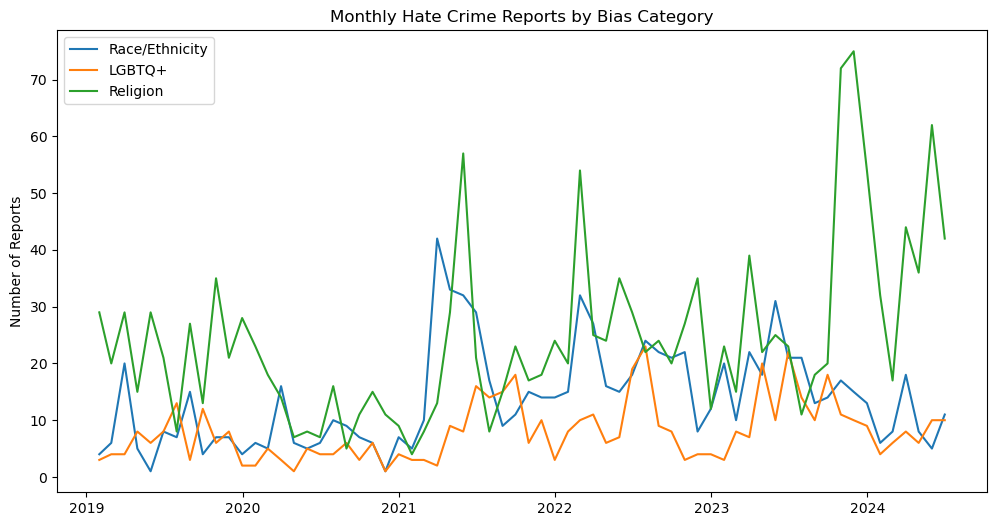

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(reports_monthly_race_ethno.index, reports_monthly_race_ethno.values, label='Race/Ethnicity')
plt.plot(reports_monthly_lgbt.index, reports_monthly_lgbt.values, label='LGBTQ+')
plt.plot(reports_monthly_rel.index, reports_monthly_rel.values, label='Religion')

plt.title('Monthly Hate Crime Reports by Bias Category')
plt.ylabel('Number of Reports')
plt.legend()
plt.show()

This section does the same analysis of frequency by category and bias motive, this time filtering to specifically violent incidents (incidents we categorized as violent based on their PD Code Description earlier in this analysis). 

In [12]:
violent_hate_crimes = hate_crimes_over_time[hate_crimes_over_time['Code Category'] == 'Violent']
violent_hate_crimes.head()

,Full Complaint ID,Complaint Year Number,Month Number,Complaint Precinct Code,Patrol Borough Name,County,Law Code Category Description,Offense Description,PD Code Description,Bias Motive Description,Offense Category,Arrest Date,Arrest Id,Code Category
Record Create Date,,,,,,,,,,,,,,
2019-09-23,201906112577217,2019,9,61,PATROL BORO BKLYN SOUTH,KINGS,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,ANTI-JEWISH,Religion/Religious Practice,NaT,NaN,Violent
2019-11-05,201906612565017,2019,11,66,PATROL BORO BKLYN SOUTH,KINGS,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,ANTI-JEWISH,Religion/Religious Practice,NaT,NaN,Violent
2019-12-25,201906612645717,2019,12,66,PATROL BORO BKLYN SOUTH,KINGS,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,ANTI-JEWISH,Religion/Religious Practice,NaT,NaN,Violent
2019-12-24,201907112820317,2019,12,71,PATROL BORO BKLYN SOUTH,KINGS,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,ANTI-JEWISH,Religion/Religious Practice,NaT,NaN,Violent
2019-01-18,201907712108817,2019,1,77,PATROL BORO BKLYN NORTH,KINGS,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,ANTI-JEWISH,Religion/Religious Practice,NaT,NaN,Violent


In [13]:
violent_by_bias = violent_hate_crimes["Bias Motive Description"].value_counts()

violent_by_cat = violent_hate_crimes["Offense Category"].value_counts()

print(violent_by_cat)
print(violent_by_bias)

Offense Category
Race/Color                            296
Sexual Orientation                    223
Religion/Religious Practice           207
Ethnicity/National Origin/Ancestry    109
Gender                                 71
Name: count, dtype: int64
Bias Motive Description
ANTI-MALE HOMOSEXUAL (GAY)          201
ANTI-ASIAN                          184
ANTI-JEWISH                         164
ANTI-WHITE                           71
ANTI-OTHER ETHNICITY                 61
ANTI-HISPANIC                        47
ANTI-TRANSGENDER                     45
ANTI-BLACK                           41
ANTI-MUSLIM                          34
ANTI-FEMALE                          23
ANTI-FEMALE HOMOSEXUAL (LESBIAN)     20
ANTI-SIKH                             7
ANTI-GENDER NON-CONFORMING            3
ANTI-LGBT (MIXED GROUP)               2
ANTI-JEHOVAHS WITNESS                 1
ANTI-ARAB                             1
ANTI-HINDU                            1
Name: count, dtype: int64


<Axes: title={'center': 'Violent Hate Crime Reports By Bias Category'}, ylabel='Offense Category'>

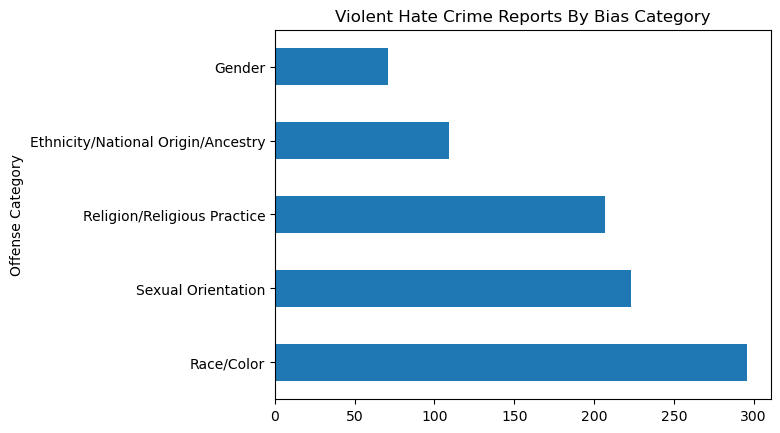

In [14]:
violent_by_cat.plot(
    title = "Violent Hate Crime Reports By Bias Category",
    x="Offense Category", 
    y="count", 
    kind="barh")

The next two cells filter and resample our data to plot violent hate crime reports against each other for each of our three categories.

In [15]:
lgbtq_hate_crimes_violent = lgbtq_hate_crimes[lgbtq_hate_crimes['Code Category'] == 'Violent']
reports_monthly_lgbt_violent = lgbtq_hate_crimes_violent.resample('ME')["Full Complaint ID"].count()

race_ethno_hate_crimes_violent = race_ethno_hate_crimes[race_ethno_hate_crimes['Code Category'] == 'Violent']
reports_monthly_race_ethno_violent = race_ethno_hate_crimes_violent.resample('ME')["Full Complaint ID"].count()

rel_hate_crimes_violent = rel_hate_crimes[rel_hate_crimes['Code Category'] == 'Violent']
reports_monthly_rel_violent = rel_hate_crimes_violent.resample('ME')["Full Complaint ID"].count()

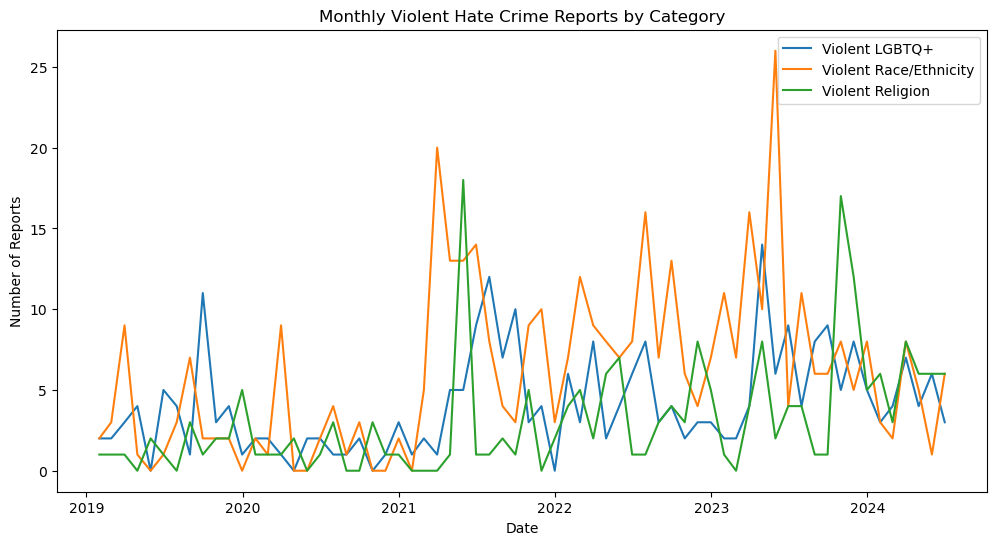

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(reports_monthly_lgbt_violent.index, reports_monthly_lgbt_violent.values, label='Violent LGBTQ+')
plt.plot(reports_monthly_race_ethno_violent.index, reports_monthly_race_ethno_violent.values, label='Violent Race/Ethnicity')
plt.plot(reports_monthly_rel_violent.index, reports_monthly_rel_violent.values, label='Violent Religion')
plt.title('Monthly Violent Hate Crime Reports by Category')
plt.xlabel('Date')
plt.ylabel('Number of Reports')
plt.legend()
plt.show()

Using the same data, this cell calculates and plots the **percentage** of total reports per bias category were violent month-to-month.  

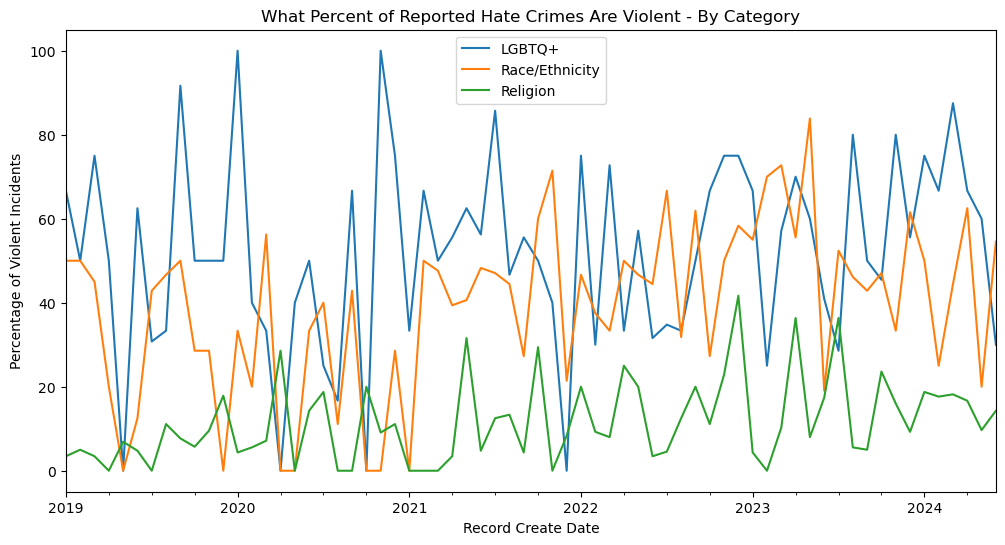

In [17]:
violent_percentages = pd.DataFrame({
    'LGBTQ+': reports_monthly_lgbt_violent / reports_monthly_lgbt * 100,
    'Race/Ethnicity': reports_monthly_race_ethno_violent / reports_monthly_race_ethno * 100,
    'Religion': reports_monthly_rel_violent / reports_monthly_rel * 100
})

violent_percentages.plot(figsize=(12, 6))
plt.title('What Percent of Reported Hate Crimes Are Violent - By Category')
plt.ylabel('Percentage of Violent Incidents')
plt.legend()
plt.show()

The next three cells plot hate crimes targeting of the three bias groups we're analyzing by code category as pie charts, breaking down reported incidents targeting each group by type. 

,Code Category,count
0,Violent,271
1,Harassment,130
2,Criminal Mischief,66
3,Burglary/Robbery,46
4,Miscellaneous,12
5,Arson,1


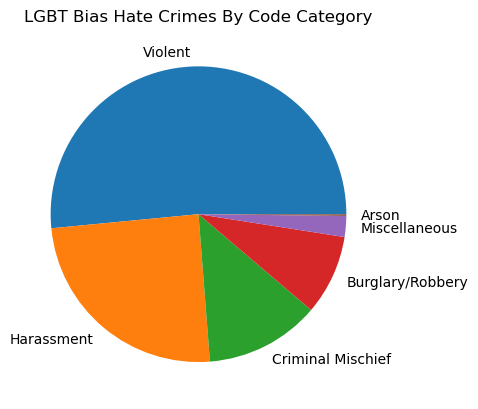

In [18]:
lgbt_by_code_cat = hate_crimes_over_time[
    (hate_crimes_over_time["Bias Motive Description"].isin(LGBTQ_motives))
]["Code Category"].value_counts().reset_index()

plt.pie(lgbt_by_code_cat["count"], labels=lgbt_by_code_cat["Code Category"])
plt.title('LGBT Bias Hate Crimes By Code Category')
plt.show
lgbt_by_code_cat

,Code Category,count
0,Violent,405
1,Harassment,268
2,Criminal Mischief,177
3,Burglary/Robbery,37
4,Miscellaneous,19


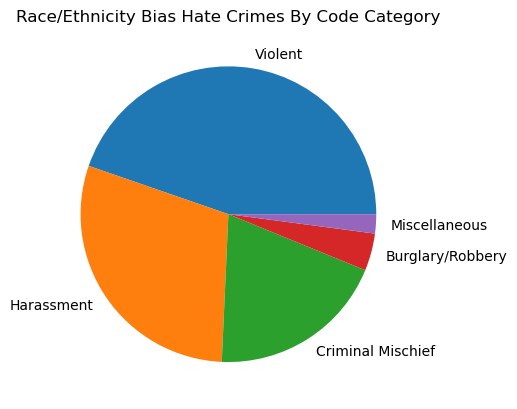

In [19]:
race_ethno_by_code_cat = hate_crimes_over_time[
    (hate_crimes_over_time['Offense Category'] == 'Race/Color') | 
    (hate_crimes_over_time['Offense Category'] == 'Ethnicity/National Origin/Ancestry')
]["Code Category"].value_counts().reset_index()

plt.pie(race_ethno_by_code_cat["count"], labels=race_ethno_by_code_cat["Code Category"])
plt.title('Race/Ethnicity Bias Hate Crimes By Code Category')
plt.show
race_ethno_by_code_cat

,Code Category,count
0,Harassment,860
1,Criminal Mischief,392
2,Violent,207
3,Burglary/Robbery,89
4,Miscellaneous,63
5,Arson,2


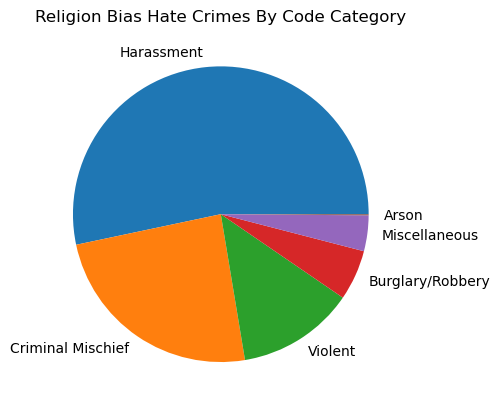

In [20]:
religion_by_code_cat = hate_crimes_over_time[
hate_crimes_over_time['Offense Category'] == 'Religion/Religious Practice'
]["Code Category"].value_counts().reset_index()

plt.pie(religion_by_code_cat["count"], labels=religion_by_code_cat["Code Category"])
plt.title('Religion Bias Hate Crimes By Code Category')
plt.show
religion_by_code_cat

## Arrest Data

This cell pulls the count of reports that resulted in an arrest by checking whether an Arrest ID or Arrest Date exist in a row.

In [21]:
all_arrests_by_cat = hate_crimes_over_time[
    (hate_crimes_over_time['Arrest Id'].notna()) | 
    (hate_crimes_over_time['Arrest Date'].notna())
]["Offense Category"].value_counts()

violent_arrests_by_cat = violent_hate_crimes[
    (violent_hate_crimes['Arrest Id'].notna()) | 
    (violent_hate_crimes['Arrest Date'].notna())
]["Offense Category"].value_counts()

all_arrests_by_cat

Offense Category
Religion/Religious Practice           504
Race/Color                            361
Sexual Orientation                    239
Ethnicity/National Origin/Ancestry    128
Gender                                 80
Unclassified                            4
Age                                     1
Name: count, dtype: int64

This cell creates a filtered dataset of reported hate crimes with an anti-LGBT bias that resulted in an arrest and saves a CSV with this filtered data. With the Arrest ID, PD Code Description, and Arrest or Report Date, this information can be used to request NYPD Arrest Reports for additional research.

In [22]:
anti_lgbt_with_arrests = hate_crimes_over_time[
    (hate_crimes_over_time['Bias Motive Description'].isin(LGBTQ_motives)) &
    ((hate_crimes_over_time['Arrest Id'].notna()) | (hate_crimes_over_time['Arrest Date'].notna()))
]
anti_lgbt_with_arrests.to_csv('../Output/anti_lgbt_hate_crime_arrests.csv', index=False)
anti_lgbt_with_arrests

,Full Complaint ID,Complaint Year Number,Month Number,Complaint Precinct Code,Patrol Borough Name,County,Law Code Category Description,Offense Description,PD Code Description,Bias Motive Description,Offense Category,Arrest Date,Arrest Id,Code Category
Record Create Date,,,,,,,,,,,,,,
2019-11-03,201901312988617,2019,11,13,PATROL BORO MAN SOUTH,NEW YORK,FELONY,MISCELLANEOUS PENAL LAW,AGGRAVATED HARASSMENT 1,ANTI-MALE HOMOSEXUAL (GAY),Unclassified,NaT,M34672420,Harassment
2019-03-16,201901812274317,2019,3,18,PATROL BORO MAN SOUTH,NEW YORK,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",ANTI-MALE HOMOSEXUAL (GAY),Sexual Orientation,NaT,M31684401,Burglary/Robbery
2019-10-05,201901812890617,2019,10,18,PATROL BORO MAN SOUTH,NEW YORK,MISDEMEANOR,CRIMINAL MISCHIEF & RELATED OF,"CRIMINAL MISCHIEF,UNCLASSIFIED 4",ANTI-MALE HOMOSEXUAL (GAY),Sexual Orientation,NaT,M31719199,Criminal Mischief
2019-05-31,201903212380917,2019,5,32,PATROL BORO MAN NORTH,NEW YORK,MISDEMEANOR,CRIMINAL MISCHIEF & RELATED OF,"MISCHIEF, CRIMINAL 4, BY FIRE",ANTI-LGBT (MIXED GROUP),Sexual Orientation,NaT,M31702799,Criminal Mischief
2019-07-08,201903212465317,2019,7,32,PATROL BORO MAN NORTH,NEW YORK,MISDEMEANOR,CRIMINAL MISCHIEF & RELATED OF,"MISCHIEF, CRIMINAL 4, BY FIRE",ANTI-MALE HOMOSEXUAL (GAY),Sexual Orientation,NaT,M31702800,Criminal Mischief
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-09,202301812343117,2023,4,18,PATROL BORO MAN SOUTH,NEW YORK,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,ANTI-MALE HOMOSEXUAL (GAY),Sexual Orientation,NaT,M35694106,Violent
2024-02-29,202400712168317,2024,2,7,PATROL BORO MAN SOUTH,NEW YORK,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,ANTI-MALE HOMOSEXUAL (GAY),Sexual Orientation,NaT,M36684873,Violent
2024-06-24,202400912375917,2024,6,9,PATROL BORO MAN SOUTH,NEW YORK,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,ANTI-MALE HOMOSEXUAL (GAY),Sexual Orientation,NaT,M36703327,Violent
